In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as tck
import numpy as np
import astropy.io.ascii
import pandas as pd

In [2]:
# Load data
sdata = astropy.io.ascii.read('mamajek_star_data.txt', data_start = 2)
stars10pc = astropy.io.ascii.read('near10pc_TOLIMAN.txt',data_start = 1)

# convert to pandas dataframe for ease of use
sdata = sdata.to_pandas()
stars10pc = stars10pc.to_pandas()

# remove duplicate column in sdata
sdata = sdata.drop('col17', axis = 1)

# rename columns to original names

sdata = sdata.rename(columns={'col1':'SpT', 'col2':'Teff', 'col3':'logT', 'col4':'BCv', 'col5':'Mv', 'col6':'logL', 'col7':'U-B', 'col8':'B-V',
                              'col9':'V-Ic',  'col10':'V-Ks', 'col11':'J-H', 'col12':'H-K', 'col13':'Ks-W1', 
                              'col14':'Msun', 'col15':'lgAge', 'col16':'b-y', 'col18':'M_J', 'col19':'M_K', 'col20':'Mbol'})

stars10pc = stars10pc.rename(columns={'col1':'Name', 'col2':'Spectrum', 'col3':'Vmag', 'col4':'Abs_Mag', 'col5':'Dist_ly'})

In [3]:
s10pc_dist = stars10pc['Dist_ly']*0.3066  # convert ly to pc
s10pc_typ = stars10pc['Spectrum'].str[:2] # strip off everything except 2-letter spectral type 
s10pc_name = stars10pc['Name']

Lbol = 10**sdata['logL'] # bolometric luminosity, units of Lsun
HZ_Orbit = np.sqrt(Lbol) # Scale bolometric for Earth - 1AU = 1Lsun. Gives same bolometric flux per m^2 at H

Stellar_Mass = sdata['Msun']
Stellar_Typ = sdata['SpT'].str[:2]

Mplanet = 1.0
Stellar_Temp = sdata['Teff']

# Work out orbital period of HZ exoplanet
Planet_Period = np.sqrt(HZ_Orbit**3 / Stellar_Mass)

In [4]:
nstars = len(s10pc_dist)
s10pc_alpha = np.zeros(nstars)
s10pc_teff = np.zeros(nstars)
s10pc_orbitperiod = np.zeros(nstars)

# Loop over our stars

for s in range(nstars):
    this_star_ix = np.where(Stellar_Typ == s10pc_typ[s])[0][0] # pick same spectral types, assumes ALL STARS ARE DWARF V
    
    # work out astrometric deflection for HZearth for this kind of star, at the known stellar dist
    s10pc_alpha[s] = 3.0 * Mplanet / Stellar_Mass[this_star_ix] * HZ_Orbit[this_star_ix] / s10pc_dist[s]
    # approx populate other useful information by copying from the template data
    s10pc_teff[s] = Stellar_Temp[this_star_ix]
    s10pc_orbitperiod[s] = Planet_Period[this_star_ix]

In [5]:
# make semi-realistic colormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('jet')
new_cmap = truncate_colormap(cmap, 0.25, 0.9)

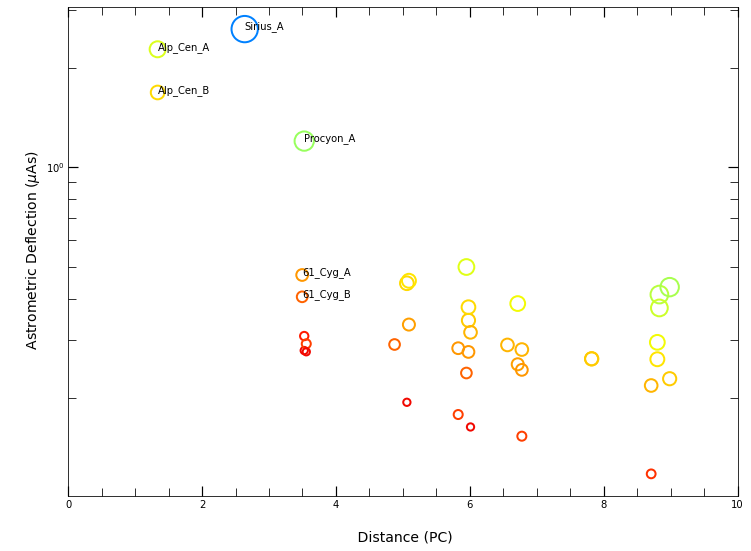

In [35]:
# plot data
circ_radius = np.sqrt(s10pc_orbitperiod)*250

fig, ax = plt.subplots(figsize = (12,9))
a = plt.scatter(s10pc_dist, s10pc_alpha, marker = 'o', s = circ_radius, c = -s10pc_teff, cmap = new_cmap, lw =2)
a.set_facecolor('none')
plt.yscale('log')
plt.xlabel('\n Distance (PC)', fontsize = 14)
plt.ylabel('\n Astrometric Deflection ($\mu$As)', fontsize = 14)
plt.xlim([0,10])
ax.minorticks_on()
ax.xaxis.set_tick_params(which='both', bottom=True, top = True)
ax.yaxis.set_tick_params(which='both', bottom=True, top = True)
ax.tick_params(axis='both', which = 'major', length = 10, width = 1.2, direction = 'in')
ax.tick_params(axis='both', which = 'minor', length = 8, width = 0.8, direction = 'in')
for s in range(nstars):
    if s10pc_alpha[s] >=  0.4:
        if s10pc_dist[s] < 4:
            plt.annotate(s10pc_name[s], (s10pc_dist[s],s10pc_alpha[s]))

plt.savefig('Astrom_10pc_TOLIMAN_someNames.pdf')